# **Post-Training BERT Model**

Part of BA Thesis by Enis Settouf

Please activate a GPU or TPU and set the Runtime-shape to high RAM (Runtime - change runtime type)


[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

# 1. Prepare Runtime


## 1.1 Install libraries

In [ ]:
!pip install datasets
!pip install transformers
!pip install sentencepiece
!pip install wandb
!apt install git-lfs

# Installing torch version and tpu client for using TPU
!pip install torch==1.8.2+cpu -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.1 MB/s 
     |████████████████████████████████| 115 kB 77.3 MB/s 
     |████████████████████████████████| 212 kB 83.4 MB/s 
     |████████████████████████████████| 120 kB 81.0 MB/s 
     |████████████████████████████████| 127 kB 86.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 70.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels

Stopping runtime to finish installs

-> Manually restart! 

In [ ]:
import os
os._exit(00)

## 1.2 Log into Huggingface and mount Google Drive 

Log into Huggingface for model upload (authentification token needed):

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Mount Google Drive to access files:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Log into Weights and Biases to track Training stats  (authentification token needed):

In [ ]:
%env "WANDB_NOTEBOOK_NAME" "post_training"
import wandb
wandb.login()

env: "WANDB_NOTEBOOK_NAME"="post_training"


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## 1.3 Connect to TPU, GPU, or CPU

Make sure to choose a GPU or TPU respectively in runtime type settings!

In [ ]:
try:
    import torch_xla.core.xla_model as xm

    device = xm.xla_device()
except:
    # Check that we have a GPU
    !nvidia-smi

    # Check that PyTorch sees 
    import torch

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

print("Device: " + device.type)

Device: xla


# 2. Preparing the Datasets

Define Dataset paths: 

In [ ]:
data_file_name_train = "/content/drive/MyDrive/ba-thesis/data-pre-processing/data_final/data_sentences_train_1p.csv"
data_file_name_validation = "/content/drive/MyDrive/ba-thesis/data-pre-processing/data_final/data_sentences_validation_1p.csv"

from datetime import datetime
date_time = datetime.now().strftime("%Y%m%d-%H%M")

model_name_ending = "openlegal"

Load train and validation set in a datasets object (doc: https://huggingface.co/docs/datasets/loading#from-local-files):

In [ ]:
from datasets import load_dataset

datasets = load_dataset("csv",
                        delimiter='_adelimiter528_',
                        encoding='utf-8',
                        column_names=['text', 'id'],
                        data_files={"train": data_file_name_train,
                                    "validation": data_file_name_validation})
datasets = datasets.remove_columns(['id', '__index_level_0__'])

datasets.shape

  0%|          | 0/2 [00:00<?, ?it/s]

{'train': (176168, 1), 'validation': (48064, 1)}

### Print random sentences from dataset:

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(datasets["train"])

,text
0,Mit Ablauf des .... 200... wurde er antragsgemaß nach § 12 des Gesetzes uber das Personaleinsatzmanagement Nordrhein-Westfalen (PEMG NRW) in den vorzeitigen Ruhestand versetzt.
1,"Auf die Frage, ob sich auch Nichtmitglieder der Antragsgegnerin auf individualvertraglicher Grundlage an deren Pools beteiligen können, kommt es für die Bestimmung des Rechtsverhältnisses der Schuldnerin zur Antragsgegnerin ebenso wenig an wie auf die weitere Frage, ob der gesonderten und jedenfalls zunächst lediglich deklaratorischen Unterzeichnung von Verwendungsbestimmungen durch die Schuldnerin nach einer Beendigung ihrer Mitgliedschaft bei der Antragsgegnerin möglicherweise rechtliche Bedeutung hätte zukommen können."
2,Insoweit ist die Rechtsbeschwerde auch im Übrigen zulässig.
3,"35 Daruber hinaus entspreche die Kurzung der Zulage von 400,00 EUR brutto auf 365,00 EUR brutto bei Vollzeitbeschaftigten (= 8,75 %) nicht der Kurzung der Zulage von 188,00 EUR brutto auf 170,00 EUR brutto bei Teilzeitbeschaftigten (9,57 %)."
4,21 Die Kostenentscheidung beruht auf § 193 SGG.
5,Die Angeklagten tragen die Kosten des Verfahrens.
6,"Hier ist der Betroffene in einem Zug einer grenzpolizeilichen Kontrolle unterzogen worden, so dass noch keine Einreise in das Bundesgebiet vorliegt; das stellt auch die Rechtsbeschwerde nicht in Abrede."
7,Der Kläger war zum Lesen der Überschrift und im Übrigen auch des Inhalts der Selbsterklärung aufgrund des Ergebnisses des Deutschtestes in der Lage; etwas Gegenteiliges hat er auch nicht behauptet.
8,57 (b) Auch die gesetzliche Systematik spricht gegen die Annahme einer Gesetzeslücke.
9,Galke | | Wellner | | von Pentz ---|---|---|---|--- | Offenloch | | Müller |


# 3. Train the Model

Masked language modeling: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.



![](https://github.com/huggingface/notebooks/blob/master/examples/images/masked_language_modeling.png?raw=1)


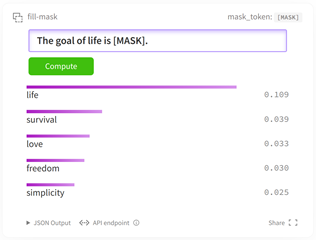

## 3.1 Set up Tokenizer

Maximum length the model was pretrained with:

In [ ]:
model_checkpoint = "T-Systems-onsite/cross-en-de-roberta-sentence-transformer"

Initialize Tokenizer:

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
block_size = tokenizer.model_max_length
print("Max token length: " + str(tokenizer.model_max_length))
#block_size = 128 # if RAM is not sufficant

Max token length: 512


Delete sentences that are longer than the maximum sequence length for the model, rather then truncating them (would otherwise result in indexing errors):



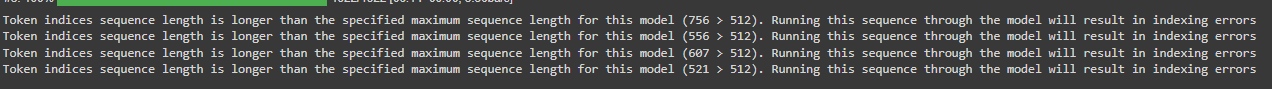

In [ ]:
datasets = datasets.filter(lambda example: len(example['text']) <= tokenizer.model_max_length)

  0%|          | 0/177 [00:00<?, ?ba/s]

  0%|          | 0/49 [00:00<?, ?ba/s]

Tokenize Datasets:

We can now call the tokenizer on all our texts. This is very simple, using the [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) method from the Datasets library. First we define a function that call the tokenizer on our texts:

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [ ]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=16, remove_columns=["text"])

#0:   0%|          | 0/11 [00:00<?, ?ba/s]

#1:   0%|          | 0/11 [00:00<?, ?ba/s]

#2:   0%|          | 0/11 [00:00<?, ?ba/s]

#3:   0%|          | 0/11 [00:00<?, ?ba/s]

#4:   0%|          | 0/11 [00:00<?, ?ba/s]

#5:   0%|          | 0/11 [00:00<?, ?ba/s]

#6:   0%|          | 0/11 [00:00<?, ?ba/s]

#7:   0%|          | 0/11 [00:00<?, ?ba/s]

#8:   0%|          | 0/11 [00:00<?, ?ba/s]

#9:   0%|          | 0/11 [00:00<?, ?ba/s]

#10:   0%|          | 0/11 [00:00<?, ?ba/s]

#11:   0%|          | 0/11 [00:00<?, ?ba/s]

#12:   0%|          | 0/11 [00:00<?, ?ba/s]

#13:   0%|          | 0/11 [00:00<?, ?ba/s]

#14:   0%|          | 0/11 [00:00<?, ?ba/s]

#15:   0%|          | 0/11 [00:00<?, ?ba/s]

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

#2:   0%|          | 0/3 [00:00<?, ?ba/s]

#3:   0%|          | 0/3 [00:00<?, ?ba/s]

#4:   0%|          | 0/3 [00:00<?, ?ba/s]

#5:   0%|          | 0/3 [00:00<?, ?ba/s]

#6:   0%|          | 0/3 [00:00<?, ?ba/s]

#7:   0%|          | 0/3 [00:00<?, ?ba/s]

#8:   0%|          | 0/3 [00:00<?, ?ba/s]

#9:   0%|          | 0/3 [00:00<?, ?ba/s]

#10:   0%|          | 0/3 [00:00<?, ?ba/s]

#11:   0%|          | 0/3 [00:00<?, ?ba/s]

#12:   0%|          | 0/3 [00:00<?, ?ba/s]

#13:   0%|          | 0/3 [00:00<?, ?ba/s]

#15:   0%|          | 0/3 [00:00<?, ?ba/s]

#14:   0%|          | 0/3 [00:00<?, ?ba/s]

## 3.2 Initialize Model that is suitable for Masked Language Modeling

Initialize Model:


Note 1: The model is a SentenceTransformer that can be used with the huggingface transformer library. No need for sentence_transformers library

Note 2: Warnings concerning missing weights can be ignored. Using the model to create embeddings, not to use the head layer, whose weights are ignored, for downstream tasks. (github[ issue](https://github.com/huggingface/datasets/issues/2569))

In [ ]:
from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint).to(device)

Some weights of XLMRobertaForMaskedLM were not initialized from the model checkpoint at T-Systems-onsite/cross-en-de-roberta-sentence-transformer and are newly initialized: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start a run for Weights and Biases:

In [ ]:
wandb.init(project="ba-thesis", entity="esettouf")

Redefine `TrainingArguments`:

In [ ]:
from transformers import TrainingArguments


model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-" + model_name_ending,
    evaluation_strategy = "steps", # epochs
#    num_train_epochs = 2, # default is 3 as per roberta paper (2-4)
    learning_rate = 1.026343323298136e-05,
    weight_decay = 0.04794438776350409,
    push_to_hub=True,
    report_to="wandb"
)

Finally, a special `data_collator` is used. The `data_collator` is a function that is responsible of taking the samples and batching them in tensors for the random-masking. A pre-processing step (like the tokenization) would be possible too but then the tokens would always be masked the same way at each epoch. By doing this step inside the `data_collator`, it is ensured this random masking is done in a new way each time it goes over the data.

For this masking, the library provides a `DataCollatorForLanguageModeling`. The probability of the masking is also adjustable:

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

Pass into `Trainer` and begin training:

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
)

Cloning https://huggingface.co/esettouf/cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-1929 into local empty directory.


## 3.3 Train Model

In [ ]:
%%time
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 62900
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23589
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss
500,6.483500,5.225894
1000,4.956900,4.516331
1500,4.415800,4.125657
2000,4.122100,3.869474
2500,3.885300,3.658590
3000,3.709200,3.512590
3500,3.577900,3.388931
4000,3.442400,3.273132
4500,3.355600,3.198404
5000,3.262700,3.110340


***** Running Evaluation *****
  Num examples = 17208
  Batch size = 8
Saving model checkpoint to cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/checkpoint-500
Configuration saved in cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/checkpoint-500/config.json
Model weights saved in cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 17208
  Batch size = 8
Saving model checkpoint to cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/checkpoint-1000
Configuration saved in cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/checkpoint-1000/config.json
Model weights saved in cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 17208
  Batch size = 8
Saving model checkpoint to cross-en-de-roberta-sentence-transformer-openlegal-1p

CPU times: user 1h 29min 44s, sys: 9min 48s, total: 1h 39min 32s
Wall time: 3h 49min 19s


Like before, we can evaluate our model on the validation set. The perplexity is much lower than for the CLM objective because for the MLM objective, we only have to make predictions for the masked tokens (which represent 15% of the total here) while having access to the rest of the tokens. It's thus an easier task for the model.

#3.4 Evaluate and Save mode: 

Evaluate Results:

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 17208
  Batch size = 8


Perplexity: 10.09


You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.save_model(f"/content/drive/MyDrive/ba-thesis/pre-training/models/{model_name}-" + model_name_ending)

Saving model checkpoint to /content/drive/MyDrive/ba-thesis/pre-training/models/cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004
Configuration saved in /content/drive/MyDrive/ba-thesis/pre-training/models/cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/config.json
Model weights saved in /content/drive/MyDrive/ba-thesis/pre-training/models/cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/pytorch_model.bin
Saving model checkpoint to cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004
Configuration saved in cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/config.json
Model weights saved in cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.33k/1.04G [00:00<?, ?B/s]

To https://huggingface.co/esettouf/cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004
   6541757..2d81b25  main -> main

   6541757..2d81b25  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Masked Language Modeling', 'type': 'fill-mask'}}
To https://huggingface.co/esettouf/cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004
   2d81b25..40122c3  main -> main

   2d81b25..40122c3  main -> main



Push model to Hugginface:

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004
Configuration saved in cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/config.json
Model weights saved in cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.33k/1.04G [00:00<?, ?B/s]

To https://huggingface.co/esettouf/cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004
   40122c3..31f72f6  main -> main

   40122c3..31f72f6  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Masked Language Modeling', 'type': 'fill-mask'}}


'https://huggingface.co/esettouf/cross-en-de-roberta-sentence-transformer-openlegal-1p-20220902-2004/commit/31f72f6a49fdd125aa1798aa4cd2a6a4fc1481f6'

Sending an email Notification:

In [ ]:
# import smtplib

# server = smtplib.SMTP('smtp.gmail.com', 587)
# server.starttls()
# server.login("email_adress", "password")

# msg = "The model is pushed to the hub."
# server.sendmail("email_adress", msg)
# server.quit()

(221,
 b'2.0.0 closing connection f22-20020a056638113600b00349bb70ab9fsm1442574jar.152 - gsmtp')

It can be accessed through `"your-username/the-name-you-picked"`:

```python
from transformers import AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained("username/model-name")
```